In [147]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import librosa
import datetime
import os

In [148]:
# The set of characters accepted in the transcription.
characters = [x for x in "tljˤʒkʃθʔabnu: zwʕmqɣfrsxiðħdh"]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 't', 'l', 'j', 'ˤ', 'ʒ', 'k', 'ʃ', 'θ', 'ʔ', 'a', 'b', 'n', 'u', ':', ' ', 'z', 'w', 'ʕ', 'm', 'q', 'ɣ', 'f', 'r', 's', 'x', 'i', 'ð', 'ħ', 'd', 'h'] (size =31)


In [149]:
# An integer scalar Tensor. The window length in samples. It is used to
# calculate the STFT of the signal.
fft_length = frame_length = 2048
# An integer scalar Tensor. The number of samples to step.
frame_step = 512
# The number of Mel frequency bins.
num_mel_bins = 128  # You can adjust this according to your needs
# sample_rate = 22050.0
# sample_rate = tf.cast(sample_rate, dtype=tf.float32)

In [150]:
@tf.function
def encode_single_sample_mel(wav_file):
    ###########################################
    # Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wav_file)
    # 2. Decode the wav file
    audio, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    audio = tf.squeeze(audio, axis=1)
    # 3. Change type to float
    # audio = tf.cast(audio, tf.float32)
    # sample_rate = tf.cast(sample_rate, tf.float32)    
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)
    num_spectrogram_bins = spectrogram.shape[-1]
    # num_spectrogram_bins = tf.cast(num_spectrogram_bins, dtype=tf.float32)
    # 5. Create mel filter
    lowest_freq = 20.0
    high_freq = tf.cast(sample_rate / 2, dtype=tf.float32)
    mel_filter = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate, lowest_freq, high_freq
    )
    # 6. Apply the filter to the spectrogram
    mel_spectrogram = tf.tensordot(spectrogram, mel_filter, 1)
    # 7. Convert to db
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    # 8. normalisation
    means = tf.math.reduce_mean(mel_spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(mel_spectrogram, 1, keepdims=True)
    mel_spectrogram = (mel_spectrogram - means) / (stddevs + 1e-10)
    
    return mel_spectrogram, wav_file


In [151]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]    
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        if result != "":
            output_text.append(result)
    return output_text

In [152]:
def decode_batch_prediction_without_ctc(pred):
    results = tf.argmax(pred, axis=2)
    output_text = []
    # print(results.shape)
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        if res != "":
            output_text.append(res)
    return output_text

In [153]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [154]:
def plot_waveform(audio, sr, title):
    # plot the first audio file
    d = len(audio) / sr
    t = np.linspace(0, d, len(audio))
    plt.figure(figsize=(14, 5))
    plt.plot(t, audio)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform of ' + title)

In [155]:
def plot_spectrogram(title, spectrogram, sr):
    # plot the spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(title)

In [158]:
abs_path = os.path.abspath('')
data_path = abs_path + "/data"
wavs_path = data_path + "/eksperimen/"

# get all files in the directory
all_files = os.listdir(wavs_path)
# filter only .wav files
wavs = [file for file in all_files if file.endswith(".wav")]
# add the full path
ds_test = [wavs_path + file for file in wavs]

In [159]:
batch_size = 4

# Define the validation dataset
test_dataset = tf.data.Dataset.from_tensor_slices(
    (list(ds_test))
)
test_dataset = (
    test_dataset.map(encode_single_sample_mel, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

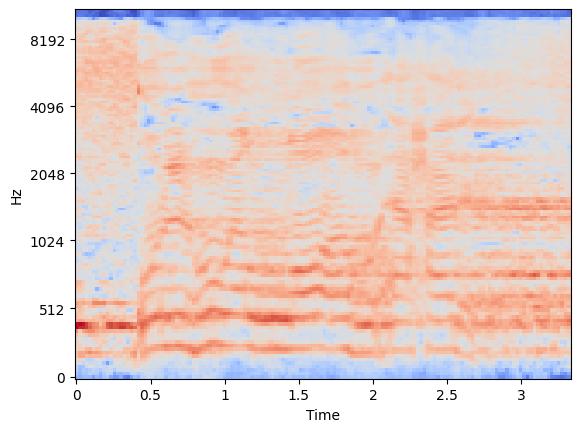

In [161]:
# fig = plt.figure(figsize=(8, 5))
for batch in test_dataset.take(1):    
    mel_spectrogram = batch[0][0].numpy()
    mel_spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(mel_spectrogram)])    
    
    # Read the audio file
    file = tf.io.read_file(batch[1][0])
    audio, sr = tf.audio.decode_wav(file)
    sr = sr.numpy()

    # plot the mel spectrogram
    librosa.display.specshow(mel_spectrogram, sr=sr, x_axis="time", y_axis="mel")    

    # display audio
    audio = audio.numpy()
    display.display(display.Audio(np.transpose(audio), rate=sr))
    
plt.show()

In [31]:
# load model .h5
new_model = keras.models.load_model("model.h5", custom_objects={"CTCLoss": CTCLoss})
new_model.summary()

Model: "DeepSpeech_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 128)]       0         
                                                                 
 expand_dim (Reshape)        (None, None, 128, 1)      0         
                                                                 
 conv_1 (Conv2D)             (None, None, 64, 32)      14432     
                                                                 
 conv_1_bn (BatchNormalizat  (None, None, 64, 32)      128       
 ion)                                                            
                                                                 
 conv_1_relu (ReLU)          (None, None, 64, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, None, 32, 32)      236544    
                                                      

In [162]:
# Let's check results on more validation samples
predictions = []
predictions_no_ctc = []
targets = []
mel_spectrograms = []

for batch in test_dataset:
    X, file = batch
    batch_predictions = new_model.predict(X)
    batch_predictions_no_ctc = decode_batch_prediction_without_ctc(batch_predictions)
    batch_predictions_ctc = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions_ctc)
    predictions_no_ctc.extend(batch_predictions_no_ctc)

    for i in range(len(X)):
        mel_spectrograms.append(X[i].numpy())
        targets.append(file[i].numpy().decode("utf-8"))

for i in range(len(predictions)):
    print(f"Prediction: {predictions[i]}")
    print(f"Prediction without CTC: {predictions_no_ctc[i]}")
    print("-" * 100)

1/1 [==============================] - 0s 185ms/step
Prediction: qul huwa lahu ʔadun
Prediction without CTC: qquuull  hhuuwwwwaaa   llllaahhuu   ʔaaaaaaddduunn
----------------------------------------------------------------------------------------------------
Prediction: qul hʕuwa lahu ʔadun
Prediction without CTC: qquull  hhʕuuuwwwwaa   llllaahhu  ʔʔaaaaadduun
----------------------------------------------------------------------------------------------------
Prediction: qul huwa lahu ʔadun
Prediction without CTC: qqquuull   hhhuuwwwaaa   llllaahhuu   ʔʔaaaaaadduun
----------------------------------------------------------------------------------------------------
Prediction: qul huwa lahu ʔadun
Prediction without CTC: qquull   hhuuwwwaa   lllllaahhuu   ʔʔaaaaaaadduun
----------------------------------------------------------------------------------------------------
Prediction: qul huwa lahu ʔadun
Prediction without CTC: qquull  hhuuwwwaa   llllaahuu  ʔaaaaaaaddunn
-----------------

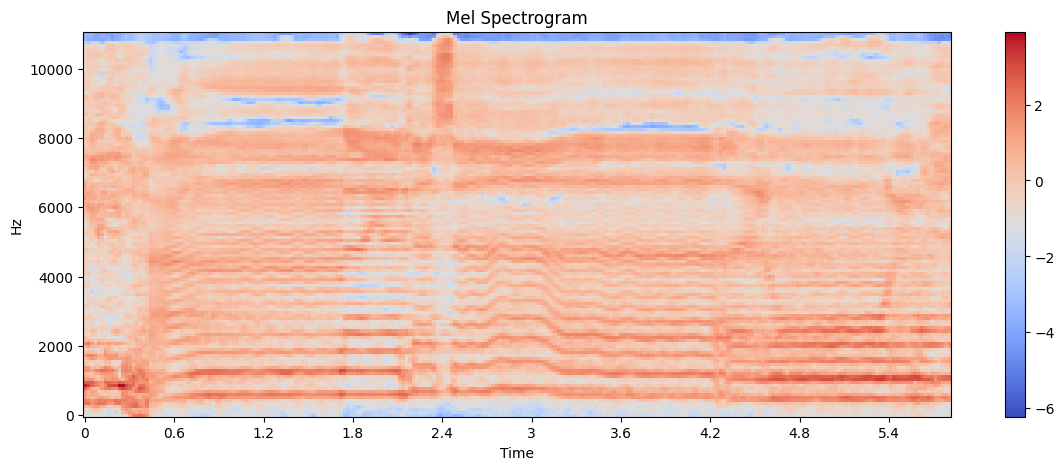

In [113]:
index = 9
file = tf.io.read_file(targets[index])
audio, sr = tf.audio.decode_wav(file)
sr = sr.numpy()
mel_spectrogram = mel_spectrograms[index]
mel_spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(mel_spectrogram)])
display.display(display.Audio(np.transpose(audio.numpy()), rate=sr))
plot_spectrogram("Mel Spectrogram", mel_spectrogram, sr)